# Sentiment Analysis of Valkyr's Rework (Warframe)

In [2]:
import pickle
import pandas as pd
import numpy as np

In [3]:
with open('data/forum_posts.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,author,likes,date,comment
0,[DE]Sam,102,May 9,"VALKYR\nTenno, A berserker’s fury fills the ai..."
1,oswarlan,352,May 10,"Honestly, losing the invulnerability on Hyster..."
2,StageNameFrank,49,May 10,"finally, valkyr's slide attack isn't the only ..."
3,18K-,10,May 10,Love it!
4,dice,18,May 10,Valkyr's Warcry is now recastable. Hooray!


## Preprocessing

The only columns that can have missing values are `author`, `date` and `comment`.

In [4]:
print(np.sum(df.loc[:, 'author'] == ''), np.sum(df.loc[:, 'date'] == ''), np.sum(df.loc[:, 'comment'] == ''))

0 0 2


In [5]:
df.loc[df.loc[:,'comment'] == '', :]

,author,likes,date,comment
93,0phiuchus,5,May 10,
1679,Heavy_Calibre,8,May 12,


Only two comments are missing, and they do not have many likes, so I will remove them:

In [6]:
df = df.loc[df.loc[:,'comment'] != '', :]
df.shape

(1898, 4)

Finally, let's reset the indexes:

In [7]:
# Reset index count, but don't store the old ones as a new column
df.reset_index(drop=True, inplace=True) 
df.tail()

,author,likes,date,comment
1893,Thyralion,0,May 12,"thats not what it ways on the post, it says ""C..."
1894,(PSN)ClockworkSiren,5,May 12,The problem is how would you increase your new...
1895,Tueneap,1,May 12,It is exactly what it says in the post. But ye...
1896,UndPanzer,10,May 12,"I love how this whole discussion is useless, e..."
1897,hambub,9,May 12,I'm starting to get really confused by some of...


### Likes as int

In [8]:
df['likes'] = df['likes'].astype('int')

# Check if NAs where created
np.sum(np.isnan(df['likes']))

np.int64(0)

### Date as datetime

In [9]:
def date_preprocessing(date: str):
    # Add year
    complete_date = date + str(' 2025')

    # Substitute ' ' separation by '-' separation
    complete_date = '-'.join(complete_date.split(' '))
    return complete_date

# Modify Date Format
df['date'] = df['date'].apply(date_preprocessing)

# Change dtype to datetime
df['date'] = pd.to_datetime(df['date']).dt.strftime('%d/%m/%Y')

### Text Cleaning
Although it is advantageous to use text as it is for sentiment analysis, later steps require cleaned text data.

In [10]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

def clean_text(text: str):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(pattern='[^a-zA-Z\d\s\']', repl='', string=text)

    # Tokenization
    words = word_tokenize(text, language='english')

    # Remove Stop-Words
    stopwords_set = set(stopwords.words('english'))
    clean_words =  [w for w in words if w not in stopwords_set and len(w) > 4]

    # Lemmatization: running, ran, runner... -> run
    wnl = WordNetLemmatizer() # initialize
    return [
        wnl.lemmatize(w, pos='v') for w in clean_words
    ]

df['clean_comment'] = df['comment'].apply(clean_text)
df.head()

,author,likes,date,comment,clean_comment
0,[DE]Sam,102,09/05/2025,"VALKYR\nTenno, A berserker’s fury fills the ai...","[valkyr, tenno, berserkers, fill, corpus, grin..."
1,oswarlan,352,10/05/2025,"Honestly, losing the invulnerability on Hyster...","[honestly, lose, invulnerability, hysteria, ki..."
2,StageNameFrank,49,10/05/2025,"finally, valkyr's slide attack isn't the only ...","[finally, valkyr, slide, attack, viable]"
3,18K-,10,10/05/2025,Love it!,[]
4,dice,18,10/05/2025,Valkyr's Warcry is now recastable. Hooray!,"[valkyr, warcry, recastable, hooray]"


## Sentiment Classification

To begin with, let's classify in basic polarities — positive, neutral and negative —, which can be done with the `nltk` library and its `VADER` lexicon.

In [11]:
# Download required lexicon 
import nltk
# nltk.download('vader_lexicon') # <--- uncomment this line to download

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER sentimen analyzer
sid = SentimentIntensityAnalyzer()

# Analyze each comment
results = {
    'index': [], 'negative_score': [], 'neutral_score': [], 
    'positive_score': [], 'compound': [], 'label': []
}

for index, post in df.iterrows():
    comment = post[-2]
    scores = sid.polarity_scores(comment)

    # Store scores
    results['index'].append(index)
    results['negative_score'].append(scores['neg'])
    results['neutral_score'].append(scores['neu'])
    results['positive_score'].append(scores['pos'])
    results['compound'].append(scores['compound'])
    results['label'].append(
        'positive' if scores['compound'] > 0.5
        else 'negative' if scores['compound'] < -0.5
        else 'neutral'
    )

C:\Users\domin\AppData\Local\Temp\ipykernel_12028\338155548.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comment = post[-2]


In [13]:
data = pd.DataFrame.from_dict(results)
data.head(10)

,index,negative_score,neutral_score,positive_score,compound,label
0,0,0.293,0.604,0.103,-0.9988,negative
1,1,0.260,0.491,0.249,-0.1027,neutral
2,2,0.220,0.780,0.000,-0.4767,neutral
3,3,0.000,0.182,0.818,0.6696,positive
4,4,0.000,0.582,0.418,0.5562,positive
5,5,0.000,0.753,0.247,0.3182,neutral
6,6,0.127,0.873,0.000,-0.4404,neutral
7,7,0.000,0.417,0.583,0.6808,positive
8,8,0.000,0.741,0.259,0.4939,neutral
9,9,0.278,0.722,0.000,-0.4019,neutral


## Data Exploration

In [14]:
data_no_introduction = data.copy()
data_no_introduction = data_no_introduction.drop(0, axis=0)

In [15]:
def compute_wordcloud(opinion_label: str, data: pd.DataFrame = data_no_introduction):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Extract comments with the same opinion
    indexes = data.loc[data['label'] == opinion_label, 'index']
    comments = df.loc[indexes, 'clean_comment']

    # List of all words in comments
    all_words = []
    for comment in comments:
        all_words.extend(comment)
    
    # Initialize WordCloud
    cloud = WordCloud(
        width=1000, height=500, background_color='black', contour_width=10,
        max_words=100, stopwords=('still', 'would')
    ).\
        generate(' '.join(all_words))
    
    # Plot WordCloud
    plt.figure(figsize=(10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud: {opinion_label} opinion comments')
    plt.show()

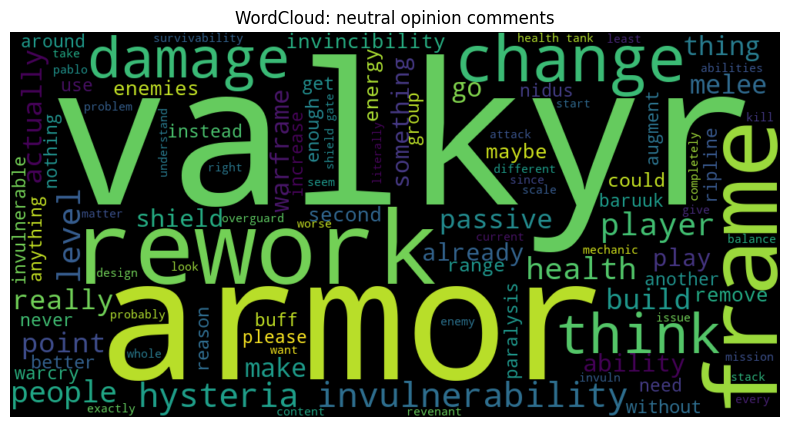

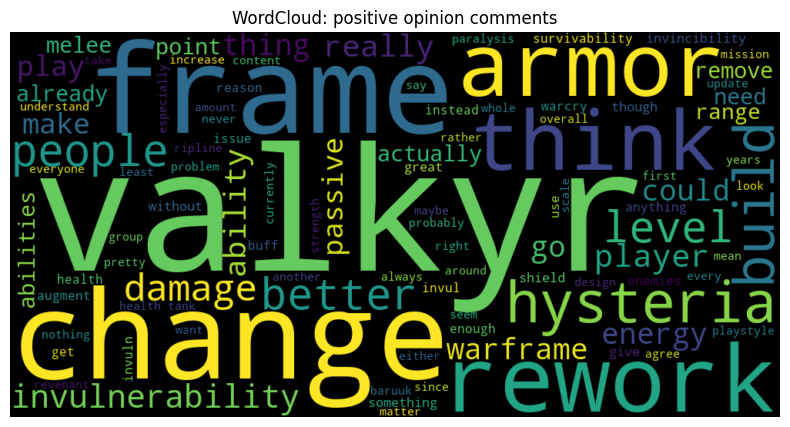

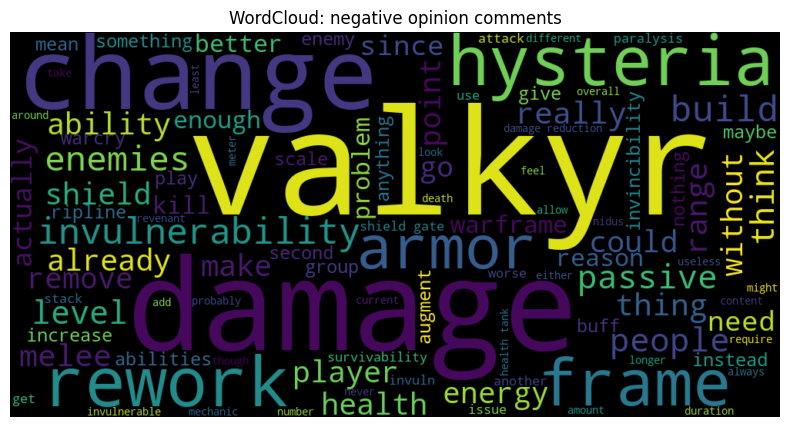

In [16]:
for opinion_label in data_no_introduction['label'].unique():
    compute_wordcloud(opinion_label)

### Polarity Weight
Which kind of opinion — positive, neutral or negative — is the most prominent:

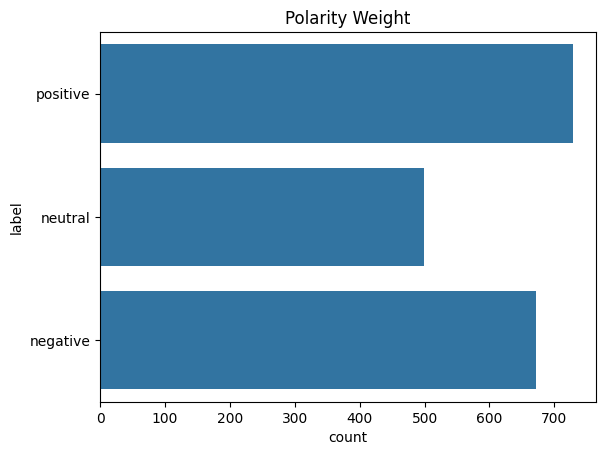

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.countplot(data['label'], order=('positive', 'neutral', 'negative'))
plt.title('Polarity Weight')
plt.show()

### Opinion evolution

In [18]:
# Join date to opinion dataframe by pandas index (on=None)
data_joined = data.join(other=df.loc[:,('date')], on=None)

# Count occurrences of each pair (date, label)
opinion_by_date = data_joined.groupby(['date', 'label']).count().iloc[:,:1]
opinion_by_date.columns = ['count']

# MultiIndex: add all possibilities (default to 0)
all_dates = df['date'].unique()
all_labels = data['label'].unique()
full_index = pd.MultiIndex.from_product([all_dates, all_labels], names=('date', 'label'))

# Reindex to include all possibilities
opinion_by_date = opinion_by_date.reindex(full_index, fill_value=0)
opinion_by_date

count
date       label          
09/05/2025 negative      1
           neutral       0
           positive      0
10/05/2025 negative    137
           neutral     153
           positive    158
11/05/2025 negative    318
           neutral     183
           positive    330
12/05/2025 negative    215
           neutral     163
           positive    240

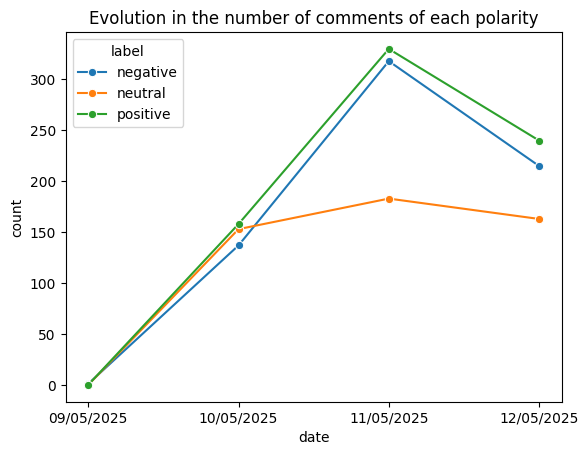

In [19]:
sb.lineplot(opinion_by_date, x='date', y='count', hue='label', marker='o')
plt.title('Evolution in the number of comments of each polarity')
plt.show()

### Top Users by sentiment
Let's analyze who are the most active and polarized users, and the most influential comments for each sentiment.

In [20]:
def compute_topNusers(opinion_label: str, df: pd.DataFrame = df, opinions: pd.DataFrame = data, N: int = 3):
    print('-' * 50)
    print(f'{opinion_label.capitalize()}')
    print('-' * 50)

    # Extract comments with the same opinion
    opinions = opinions.iloc[1:, :] # skip introduction post
    indexes = opinions.loc[opinions['label'] == opinion_label, 'index']
    opinions = opinions.loc[indexes, :]

    df = df.iloc[1:, :] # skip introduction post
    comments = df.loc[indexes, :]

    # Top N most active users
    active = comments.groupby('author')['comment'].count().sort_values(ascending=False)[:N]
    
    
    print(f'Top {N} most active users:')
    for user in active.index.values:
        print(f'· {user} ({active.loc[user]} comments)')
    print('') # skip line

    # Top N most polarized users
    compound_opinions = opinions.loc[:, ('compound',)].copy() # focus on compound opinion
    compound_opinions['author'] = comments.loc[:, ('author')] # add author
    compound_opinions = compound_opinions.groupby('author')['compound'].\
        mean().abs().\
        sort_values(ascending=False)[:N]
    
    print(f'Top {N} polarized users:')
    for (author, compound) in compound_opinions.items():
        print(f'· {author} ({np.round(compound, 4) * 100} % {opinion_label})')
    print('') # skip line

    # Top N most influential comments
    influential = comments.sort_values(by='likes', ascending=False)['comment'].iloc[:N]

    print(f'Top {N} influential comments:')
    for index, comment in influential.items():
        print(f'· {comment}')

    print('\n')

compute_topNusers('positive')
compute_topNusers('neutral')
compute_topNusers('negative')

--------------------------------------------------
Positive
--------------------------------------------------
Top 3 most active users:
· VoidIII (66 comments)
· A-Midnight-Shanking (29 comments)
· PrimedLaundrySauce (28 comments)

Top 3 polarized users:
· Twitchh13 (99.52 % positive)
· TeaJunkie (99.45 % positive)
· AtraUnam (99.42 % positive)

Top 3 influential comments:
· She does way more damage She did 14millions per hit reliably, sometimes more. She doesnt need dmg, but better abilities in general. Now, we end with more or less the same abilities, somewhat improved, but at the same time now you will need to invest into shield tanking, so you will get less mods for your abilities. Overall, nerfed.
· Adding damage to a frame that hit damage cap with ease and removing her invulnerability basically killed her but thank for the free Warframe slots now
· Hysteria no longer turns Valkyr invulnerable.  Great, Valk will be dead on arrival with this specific change. 

Please look at Ember 

### Sentiment vs Engagement
Mean number of likes per opinion.

In [21]:
engagement = df.loc[:, ('likes',)].join(
    other=data.loc[:, ('label',)], on=None # = on pandas index
)

engagement.groupby('label').mean()

,likes
label,
negative,6.612519
neutral,10.877756
positive,4.585165


Neutral and negative posts have better engagement.

### Frequent Phrases
Identify common 2-word and 3-word phrases in a sentiment category (N-grams).

In [22]:
def find_NGrams(opinion_label: str, N_min: int = 2, N_max: int = 3, topN: int = 10):
    from sklearn.feature_extraction.text import CountVectorizer
    # Initialize N-Gram counter
    vectorizer = CountVectorizer(
        ngram_range=(N_min, N_max), stop_words='english'
    )

    # Initialize data
    comments = df.loc[data['label'] == opinion_label, 'clean_comment']
    joined_comments = comments.transform(lambda x: ' '.join(x))
    
    # Find N-Grams
    X = vectorizer.fit_transform(joined_comments)

    # Count repetition
    count_ngrams = X.sum(axis=0)
    phrases = [
        (ngram, count_ngrams[0, idx])
        for (ngram, idx) in vectorizer.vocabulary_.items()
    ]

    # Sort descending
    phrases = sorted(phrases, key=lambda x: x[1], reverse=True)

    # Show results
    print(f'Most Common N-Grams in {opinion_label.capitalize()} Comments:')
    for idx in range(topN):
        phrase = phrases[idx][0]
        count = phrases[idx][1]
        print(f'{phrase}: {count}')
    print('') # skip line

for label in data['label'].unique():
    find_NGrams(opinion_label=label)

Most Common N-Grams in Negative Comments:
shield gate: 94
damage reduction: 83
health tank: 74
melee damage: 56
slide attack: 55
energy drain: 53
health armor: 52
second invulnerability: 41
higher level: 37
level content: 36

Most Common N-Grams in Neutral Comments:
health tank: 30
shield gate: 24
damage reduction: 20
valkyr rework: 19
level content: 18
remove invulnerability: 14
play valkyr: 14
health armor: 13
build range: 10
diminish return: 10

Most Common N-Grams in Positive Comments:
health tank: 65
shield gate: 50
valkyr rework: 45
damage reduction: 45
health armor: 42
armor health: 42
level content: 36
melee frame: 36
remove invulnerability: 35
play valkyr: 28



### LDA: Topic Modeling per Sentiment

In [ ]:
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx + 1}:")
        print(", ".join([words[i] for i in topic.argsort()[-top_n:]]))

def lda_topic_extraction(label_opinion: str, n_topics: int = 3, seed: int = 33):
    from sklearn.decomposition import LatentDirichletAllocation
    from sklearn.feature_extraction.text import CountVectorizer

    # Build Subset
    subset = df.loc[data['label'] == label_opinion, 'comment']

    # Vectorize comments and count words
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(subset)

    # Perform LDA: extract topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=seed)
    lda.fit(X)

    # Print topics
    print_topics(lda, vectorizer)

for topic_label in data['label'].unique():
    print('-' * 50)
    print(f'Top 3 Topics from {topic_label.capitalize()} Comments')
    print('-' * 50)
    lda_topic_extraction(topic_label)
    print('')

--------------------------------------------------
Top 3 Topics from Negative Comments
--------------------------------------------------
(671,)

Topic #1:
passive, really, death, guna, melee, just, valkyr, 75, rage, damage

Topic #2:
rage, invulnerability, rework, health, hysteria, like, armor, just, valkyr, damage

Topic #3:
melee, game, rework, like, enemies, damage, people, frame, valkyr, just

--------------------------------------------------
Top 3 Topics from Neutral Comments
--------------------------------------------------
(499,)

Topic #1:
dr, frame, game, health, invulnerability, like, rework, armor, just, valkyr

Topic #2:
melee, just, valkyr, energy, like, use, range, hysteria, rework, damage

Topic #3:
valkyr, make, high, rage, just, damage, cap, armor, like, level

--------------------------------------------------
Top 3 Topics from Positive Comments
--------------------------------------------------
(728,)

Topic #1:
use, people, rework, play, frame, game, don, like, j

### LDA: Focused Model on 'Health'

In [48]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Focus on health related comments
health_df = df[df['comment'].str.contains('health', case=False, na=False)]
health_df = health_df['comment']

# Vectorize comments and count words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(health_df)

# Perform LDA: extract topics
lda = LatentDirichletAllocation(n_components=3, random_state=33)
lda.fit(X)

# Visualize with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer)
pyLDAvis.display(panel)